In [1]:
import numpy as np
import matplotlib.pyplot as plt

from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)


from yadlt.model import generate_pdf_model, mc_integrate_from_mvg, compute_K_by_layer
from yadlt.plotting.plotting import produce_mat_plot
from yadlt.context import FitContext

In [2]:
import logging
from yadlt.log import setup_logger

# Set up the root logger to capture all logs in jupyter notebook
logger = setup_logger()

# If you want to see all messages, including DEBUG:
logger.setLevel(logging.INFO)

In [3]:
fitname = "250713-01-L0-nnpdf-like"

In [4]:
# Load context
context = FitContext(fitname, force_serialize=False)

In [ ]:
fk_grid = context.load_fk_grid()

In [6]:
architecture_tuple = tuple(context.get_config("metadata", "model_info")["architecture"])
seed = context.get_config("metadata", "arguments")["seed"]

nreplicas = 100
x = np.array(fk_grid).reshape(1, -1, 1)
model_ens = []

for rep in range(nreplicas):
    model = generate_pdf_model(
        outputs=1,
        architecture=[500],
        activations=["tanh"],
        kernel_initializer="GlorotNormal",
        user_ki_args=None,
        seed=seed + rep,
        scaled_input=False,
        preprocessing=False,
    )

    model_ens.append(model)

# First layer

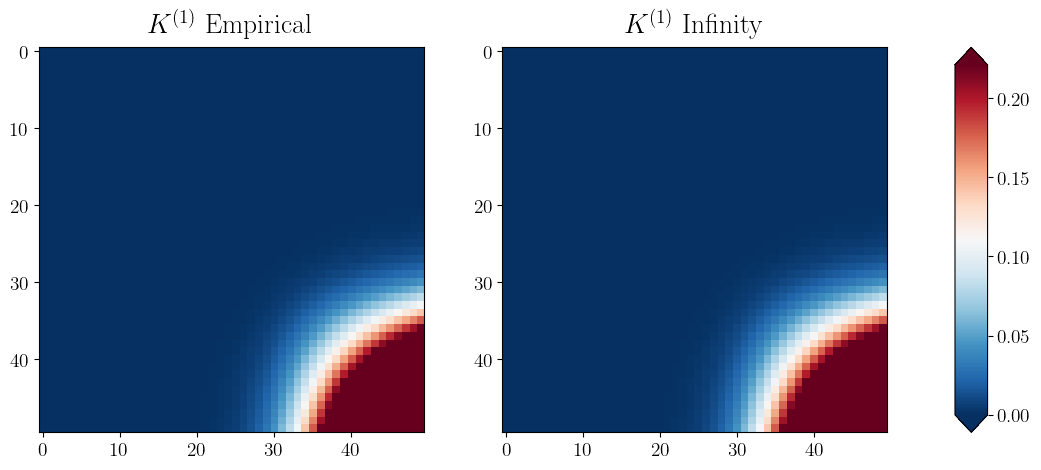

In [7]:
K1_empirical = compute_K_by_layer(model_ens, 0, fk_grid).numpy().squeeze()
K1_infinity = np.outer(fk_grid, fk_grid)

produce_mat_plot(
    [K1_empirical, K1_infinity],
    [r"$K^{(1)} \textrm{ Empirical}$", r"$K^{(1)} \textrm{ Infinity}$"],
)

# Second layer (first deep layer)

### Compute the empirical kernel

In [8]:
# Second layer
K2_empirical = compute_K_by_layer(model_ens, 1, fk_grid)

# Plot one diagonal element and one off-diagonal element
K2_diag = K2_empirical[:,0,:,0].numpy()
K2_offdiag = K2_empirical[:,0,:,50].numpy()

### Compute the theoretical kernel

In [9]:
def activation_moment(x):
    """
    Compute the activation moment for a given input x.
    """
    return np.outer(np.tanh(x), np.tanh(x))

rho_rho_mean, rho_rho_std = mc_integrate_from_mvg(activation_moment, 
                                                  np.zeros(K1_empirical.shape[0]), 
                                                  K1_infinity, 
                                                  num_samples=1000,
                                                  batch_size=100)

In [10]:
Cw = 2 / (200 + 1)
K2_infinity = Cw * rho_rho_mean

### Plot the empirical and theoretical kernels

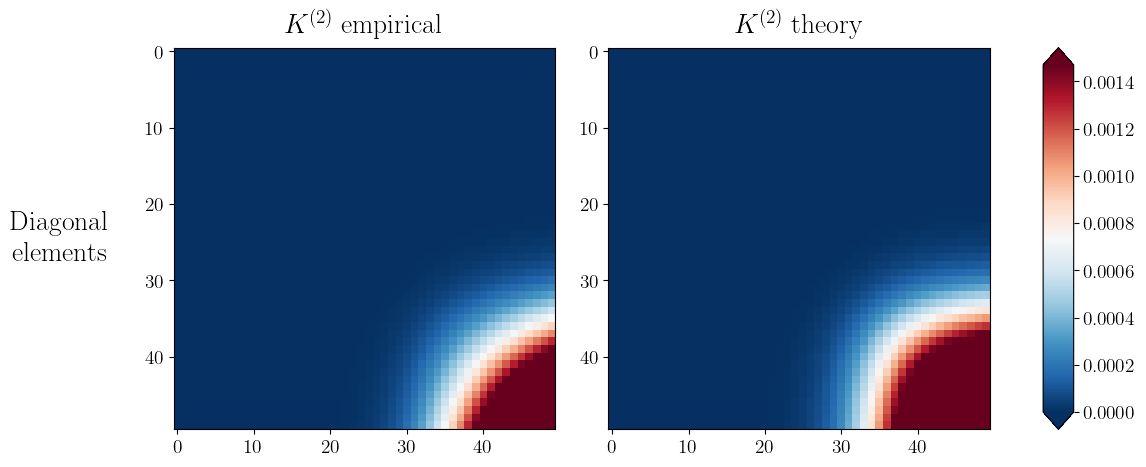

In [30]:
produce_mat_plot([K2_diag, K2_infinity], 
                 [r"$K^{(2)}~\rm{empirical}$", r"$K^{(2)}~\rm{theory}$"],
                 text_dict={"x": -0.3, "y": 0.5, "s": r"$\textrm{Diagonal}$" + "\n" + r"$\rm{elements}$"})

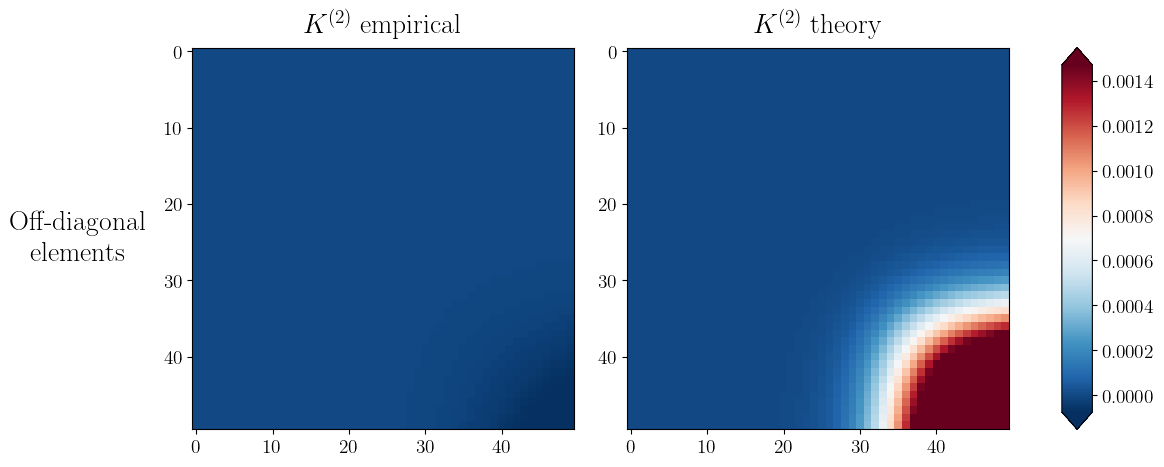

In [28]:
produce_mat_plot([K2_offdiag, K2_infinity], 
                 [r"$K^{(2)}~\rm{empirical}$", r"$K^{(2)}~\rm{theory}$"],
                 text_dict={"x": -0.3, "y": 0.5, "s": r"$\textrm{Off-diagonal}$" + "\n" + r"$\rm{elements}$"})